In [1]:
import pandas as pd 
import os 
import pathlib 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

maindir = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/from_VM/UMI_FROM_R1_ONLY"
path_to_02_output = "/media/hieunguyen/HNHD01/outdir/ampliconSeq/from_VM/UMI_FROM_R1_ONLY_data_analysis"
os.system(f"mkdir -p {path_to_02_output}")

all_umi_files = [item for item in pathlib.Path(maindir).glob("*.txt")]

all_potential_umis = [f"{a}{s}{d}{f}{g}{h}" for a in "ACGT" for s in "ACGT" for d in "ACGT" for f in "ACGT" for g in "ACGT" for h in "ACGT"]

umidf = pd.DataFrame(all_potential_umis, columns=["umi"])
umi_pct_df = pd.DataFrame(all_potential_umis, columns=["umi"])
entropydf = pd.DataFrame()
rerun = True
if os.path.isfile(os.path.join(path_to_02_output, "all_umis.txt")) == False or rerun == True:
    for file in tqdm(all_umi_files):
        sampleid = file.name.replace(".UMI.txt", "")
        if sampleid != "45-TMS7E_S7545-S7745":
            tmpdf = pd.read_csv(file, sep="\t", header=None, names=["umi"])
            tmpdf = tmpdf[tmpdf["umi"].str.contains("N") == False]
            tmpdf = tmpdf.reset_index().groupby("umi")["index"].count().reset_index()
            tmpdf.columns = ["umi", sampleid]
            tmpdf[sampleid] = tmpdf[sampleid].astype(int)
            tmpdf[f"pct_{sampleid}"] = tmpdf[sampleid].apply(lambda x: 100 * x / tmpdf[sampleid].sum())
            shannon_entropy = -np.sum([item * np.log2(item) for item in tmpdf[f"pct_{sampleid}"].values if item > 0])/len(all_potential_umis)
            umidf = umidf.merge(tmpdf[["umi", sampleid]], right_on = "umi", left_on= "umi", how="left")
            umi_pct_df = umi_pct_df.merge(tmpdf[["umi", f"pct_{sampleid}"]], right_on = "umi", left_on= "umi", how="left")
            tmp_entropydf = pd.DataFrame({"sampleid": [sampleid], "shannon_entropy": [shannon_entropy]})
            entropydf = pd.concat([entropydf, tmp_entropydf], ignore_index=True)
    umidf = umidf.fillna(0)
    umi_pct_df = umi_pct_df.fillna(0)

    umidf.to_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t", index=False)
    umi_pct_df.to_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t", index=False)
    entropydf.to_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t", index=False)
else:
    umidf = pd.read_csv(os.path.join(path_to_02_output, "all_umis.txt"), sep="\t")
    umi_pct_df = pd.read_csv(os.path.join(path_to_02_output, "all_umis_pct.txt"), sep="\t")
    entropydf = pd.read_csv(os.path.join(path_to_02_output, "umi_entropy.txt"), sep="\t")


100%|██████████| 110/110 [01:07<00:00,  1.64it/s]


(0.0, 1.0)

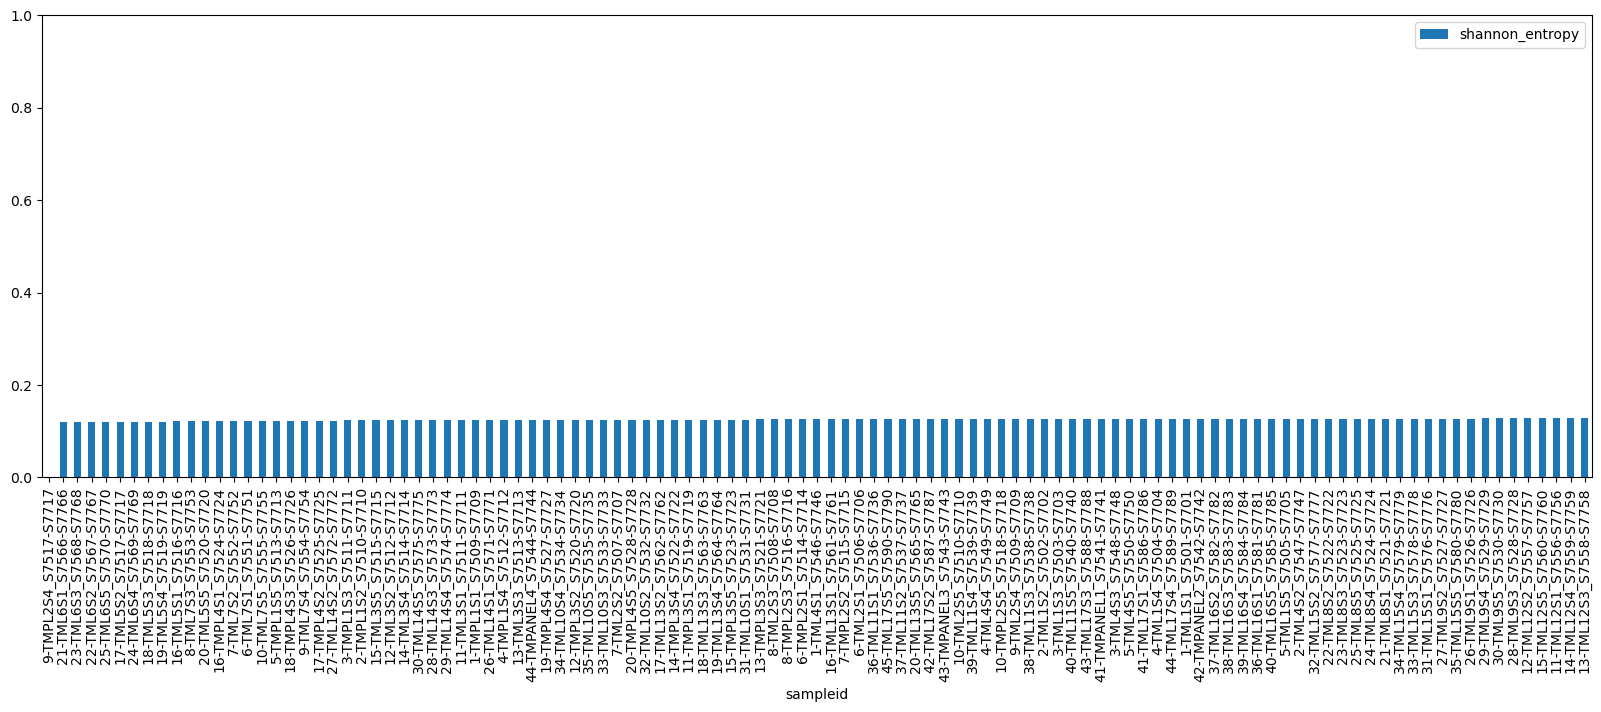

In [2]:

entropydf.sort_values(by="shannon_entropy", ascending=True, inplace=True)
entropydf.set_index("sampleid").plot.bar(figsize = (20,6))
plt.ylim([0, 1])


<Axes: xlabel='max_umi'>

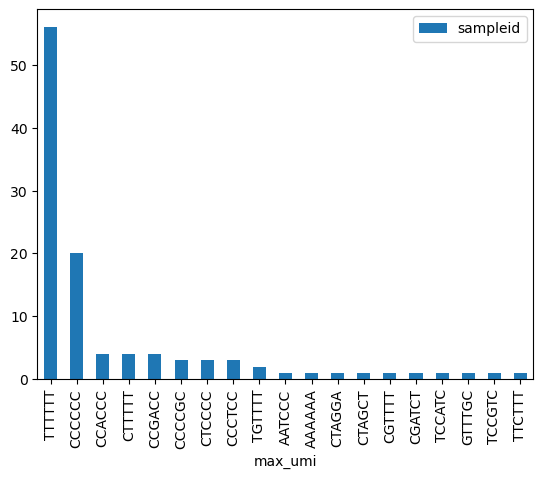

In [13]:
count_max_df = pd.DataFrame()
for sampleid in umidf.columns[1:]:
    max_umi = umidf[umidf[sampleid] == umidf[sampleid].max()]["umi"].values[0]
    top5_umi = umidf.sort_values(by=sampleid, ascending=False).head(5)
    tmpcount_max_df = pd.DataFrame({"sampleid": [sampleid], 
                                    "max_umi": [max_umi], 
                                    "max_5_umi": ",".join(sorted(top5_umi["umi"].to_list())),
                                    "max_count": [umidf[sampleid].max()],
                                    "max_pct": [umi_pct_df[f"pct_{sampleid}"].max()]})
    count_max_df = pd.concat([count_max_df, tmpcount_max_df], ignore_index=True)
count_max_df.groupby("max_umi")["sampleid"].count().sort_values(ascending=False).reset_index().plot.bar(x = "max_umi")


In [14]:
count_max_df.groupby("max_umi")["sampleid"].count().sort_values(ascending=False).reset_index()

,max_umi,sampleid
0,TTTTTT,56
1,CCCCCC,20
2,CCACCC,4
3,CTTTTT,4
4,CCGACC,4
5,CCCCGC,3
6,CTCCCC,3
7,CCCTCC,3
8,TGTTTT,2
9,AATCCC,1


In [26]:
umi_pct_df.sort_values(by="pct_20-TML5S5_S7520-S7720", ascending=False, inplace=True)
umi_pct_df.head(10)

,umi,pct_20-TML5S5_S7520-S7720,pct_1-TML4S1_S7546-S7746,pct_5-TMPL1S5_S7513-S7713,pct_23-TML8S3_S7523-S7723,pct_4-TMPL1S4_S7512-S7712,pct_12-TML3S2_S7512-S7712,pct_16-TMPL4S1_S7524-S7724,pct_2-TML4S2_S7547-S7747,pct_7-TMPL2S2_S7515-S7715,...,pct_19-TML13S4_S7564-S7764,pct_28-TML9S3_S7528-S7728,pct_14-TML12S4_S7559-S7759,pct_41-TMPANEL1_S7541-S7741,pct_22-TML6S2_S7567-S7767,pct_32-TML10S2_S7532-S7732,pct_10-TML7S5_S7555-S7755,pct_12-TML12S2_S7557-S7757,pct_17-TMPL4S2_S7525-S7725,pct_30-TML9S5_S7530-S7730
4095,TTTTTT,0.288270,0.075114,0.311793,0.175901,0.250551,0.021084,0.351821,0.077224,0.078007,...,0.117317,0.126813,0.029720,0.120948,0.313586,0.211123,0.232456,0.009923,0.183748,0.132580
3327,TATTTT,0.147292,0.046831,0.150326,0.083031,0.122952,0.022590,0.133944,0.043259,0.053164,...,0.073472,0.069317,0.027298,0.062140,0.113710,0.115688,0.069557,0.014751,0.093320,0.071336
1023,ATTTTT,0.129662,0.033612,0.127366,0.095240,0.109129,0.017821,0.130971,0.037998,0.066083,...,0.085305,0.074449,0.020688,0.065102,0.126541,0.100429,0.049593,0.009762,0.085709,0.075928
4093,TTTTTC,0.128036,0.046728,0.135925,0.066615,0.109710,0.015688,0.164544,0.046299,0.082479,...,0.082462,0.065014,0.020990,0.069703,0.161619,0.082951,0.081363,0.012498,0.119809,0.066157
2047,CTTTTT,0.127349,0.057181,0.118196,0.085165,0.100708,0.021461,0.154053,0.048696,0.061114,...,0.109613,0.071598,0.044756,0.055318,0.153850,0.074906,0.091142,0.048704,0.161979,0.072617
4087,TTTTCT,0.124160,0.044679,0.129268,0.073252,0.105993,0.017194,0.159124,0.046007,0.055152,...,0.080352,0.068695,0.025431,0.068909,0.150319,0.086835,0.062903,0.013088,0.120418,0.068933
3583,TCTTTT,0.122535,0.045191,0.125464,0.075682,0.102392,0.027736,0.159124,0.050099,0.050183,...,0.083654,0.071131,0.035825,0.059126,0.156086,0.099319,0.086918,0.029877,0.151474,0.070855
4063,TTTCTT,0.121285,0.035354,0.127434,0.069696,0.104251,0.026481,0.167167,0.035835,0.038755,...,0.086956,0.068798,0.031082,0.065895,0.158558,0.088222,0.120424,0.017164,0.128639,0.063434
4092,TTTTTA,0.117346,0.035046,0.130016,0.081490,0.111278,0.013303,0.128348,0.034257,0.040743,...,0.063841,0.057963,0.014431,0.065895,0.105352,0.094603,0.050287,0.005686,0.073682,0.058361
4047,TTTATT,0.114720,0.032075,0.120505,0.067563,0.096701,0.018825,0.125725,0.030691,0.042233,...,0.072280,0.068954,0.025380,0.063621,0.114887,0.107642,0.070078,0.010138,0.077792,0.068666


In [4]:
count_max_df.groupby("max_5_umi")["sampleid"].count().sort_values(ascending=False).reset_index()

,max_5_umi,sampleid
0,"CCCCCC,CCCCTC,CCCTCC,CTCCCC,TCCCCC",5
1,"TCTTTT,TTCTTT,TTTCTT,TTTTTC,TTTTTT",5
2,"CCTCCC,CCTCCT,CCTCTC,CCTTCC,TTTTTT",4
3,"ATTTTT,TATTTT,TTTTTA,TTTTTC,TTTTTT",3
4,"ATTTTT,CTTTTT,TCTTTT,TTCTTT,TTTTTT",3
...,...,...
78,"TACTTT,TCTTTT,TTCATT,TTCTTT,TTTTTT",1
79,"TATTTT,TCTTTT,TTATTT,TTCTTT,TTTTTT",1
80,"TATTTT,TTTTCT,TTTTTA,TTTTTC,TTTTTT",1
81,"TCTTTT,TTCTTT,TTTTCT,TTTTTC,TTTTTT",1


<Axes: xlabel='umi'>

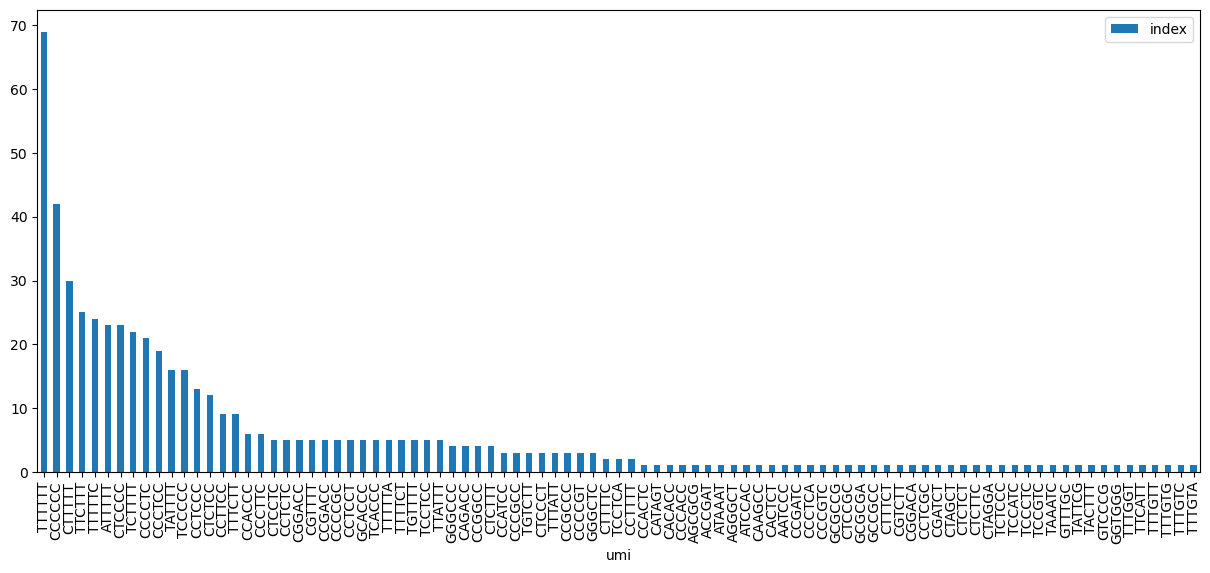

In [54]:
all_motifs = []
[[all_motifs.append(j) for j in item.split(",")] for item in count_max_df.max_5_umi.to_list()]
count_top5 = pd.DataFrame(data = all_motifs, columns =["umi"])
count_top5.reset_index().groupby("umi")["index"].count().sort_values(ascending=False).reset_index().plot.bar(figsize=(15, 6), x="umi", y="index")

In [41]:
len(set(all_motifs))

91

In [5]:
checkdf = umidf[["umi", "34-TML10S4_S7534-S7734"]].sort_values(by="34-TML10S4_S7534-S7734", ascending=False)
checkdf[checkdf["umi"] == "CTTGGC"]

,umi,34-TML10S4_S7534-S7734
2025,CTTGGC,42


In [6]:
checkdf

,umi,34-TML10S4_S7534-S7734
4095,TTTTTT,565
3903,TTATTT,401
3967,TTCTTT,382
3327,TATTTT,314
3583,TCTTTT,284
...,...,...
335,ACCATT,8
1107,CACCAT,5
2131,GACCAT,4
3155,TACCAT,4


In [7]:
tmpdf = umidf[["umi", sampleid]].sort_values(by=sampleid, ascending=True)
tmpdf["accumsum"] = tmpdf[sampleid].cumsum()

In [8]:
from itertools import combinations

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

umi_counts = dict(zip(tmpdf['umi'], tmpdf[sampleid]))

merged = set()
new_umi_counts = {}

for umi in tmpdf['umi']:
    if umi in merged:
        continue
    # Find UMIs with hamming distance <= 1
    similar = [umi2 for umi2 in tmpdf['umi'] if umi2 != umi and hamming_distance(umi, umi2) <= 1]
    total_count = umi_counts[umi]
    for umi2 in similar:
        if umi2 not in merged:
            total_count += umi_counts[umi2]
            merged.add(umi2)
    new_umi_counts[umi] = total_count
    merged.add(umi)

combined_UMI = pd.DataFrame(list(new_umi_counts.items()), columns=['umi', sampleid]).sort_values(sampleid, ascending=False).reset_index(drop=True)

In [9]:
combined_UMI

,umi,30-TML9S5_S7530-S7730
0,TCGTGT,7949
1,AACCCC,6172
2,GTCGTG,5903
3,CGTGTA,5881
4,TAGCTT,5806
...,...,...
706,ACTGAT,520
707,CCCGGA,518
708,ATCAAC,476
709,AGGGGC,412


<Axes: >

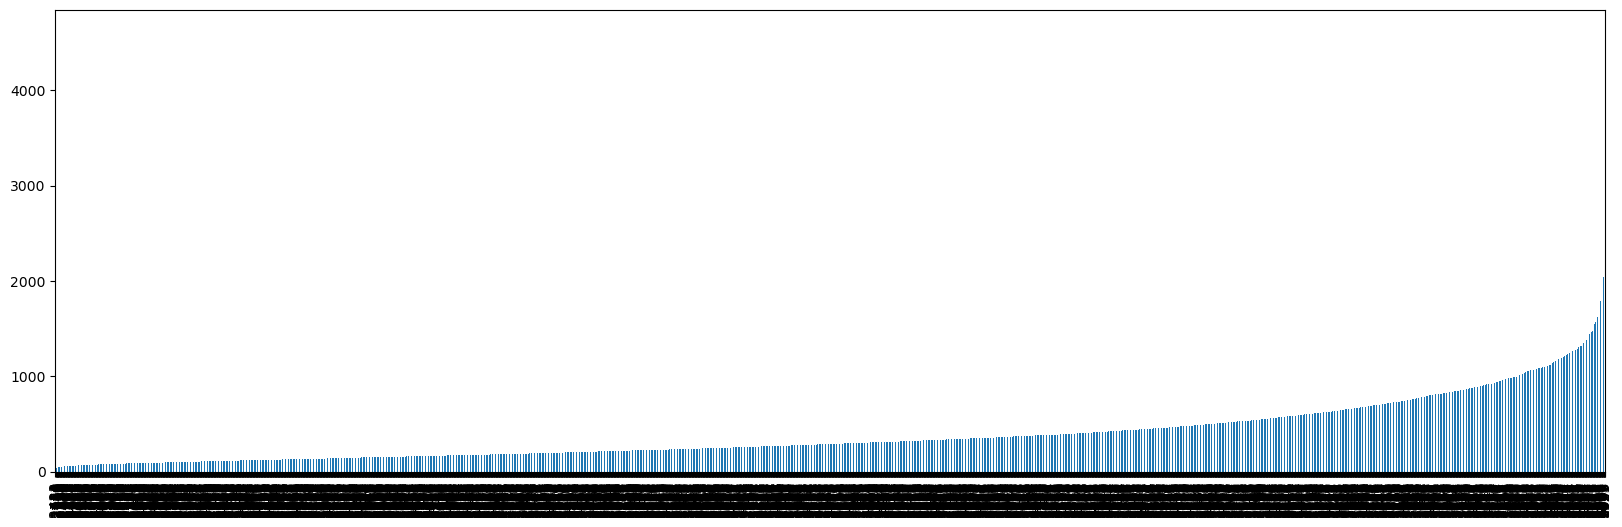

In [20]:
umidf.sort_values(by = "20-TML5S5_S7520-S7720")["20-TML5S5_S7520-S7720"].plot.bar(figsize=(20,6))